In [112]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gzip 
# Input data files are available in the "../input/" directory.
# For preprocessing
from sklearn import preprocessing

import os
# print(os.listdir('../'))
print(os.listdir("../input"))
print("pandas: {}".format(pd.__version__))
print('numpy: {}'.format(np.__version__))
# Any results you write to the current directory are saved as output.

['shops.csv', 'item_categories.csv', 'sales_train.csv', 'items.csv', 'sample_submission.csv', 'test.csv']
pandas: 0.23.4
numpy: 1.16.2


# Load Data as dataframes

In [ ]:
shops_df = pd.read_csv('../input/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})  
                            # columns: ['shop_name','shop_id']
item_cat_df = pd.read_csv('../input/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'}) 
                            # columns: ['item_category_name', 'item_category_id']
sales_train_df  = pd.read_csv('../input/sales_train.csv',parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'}) 
                            # ['date','date_block_num','shop_id','item_id','item_price', 'item_cnt_day']
items_df = pd.read_csv('../input/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})  
                            # ['item_name','item_id','item_category_id']
sample_sub_df = pd.read_csv('../input/sample_submission.csv')  # ['ID',item_cnt_month']
test_df = pd.read_csv('../input/test.csv',dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'}) # [shop_id','item_id']

## Ideas: 
After a little EDA and some thought, I've arrived to the following ideas about this problem:
*  Use `['shop_id','item_id']` as the index, it is more convenient (I believe, let's see)
*  Compare the train and test datasets to understand how they were split - this will help with the private score-
*  You need some criteria to fill in the missing values in the train dataset. I believe this is achived through feature engineering.
* We will start with Decission Trees, XGBoost, Random Forest, linear regression and knn regression. In all cases (except by knn maybe) we will need a lot of features, so we will start with feature creation. Remember that we are dealing with time series, this means that time is a relevant variable. 

Let's compare the pairs `['shop_id','item_id']` in train and test datasets, there are a few things to note:
  * There are no pairs for `'shop_id'=0,1`. This might, at first, suggest that we could get rid of those pairs in the training set. Look for the evolution of stores through time, since there are closings and openings of stores, this could lead to reducing the number of shops in considereation.
  * There are pairs in test that do not appear in train, this arises the question of whether and how to include those pairs into the train dataset


In [ ]:
# Unique ['shop_id','item_id'] pairs in train dataset
train_pairs = sales_train_df[['shop_id','item_id']].sort_values(['shop_id','item_id']).drop_duplicates().reset_index(drop=True)

# Unique ['shop_id','item_id'] pairs in train dataset
test_pairs = test_df[['shop_id','item_id']].sort_values(['shop_id','item_id']).drop_duplicates().reset_index(drop=True)
print("Number of train unique pairs: {}".format(train_pairs.shape))
print("Number of test unique pairs: {}".format(test_pairs.shape))

In [ ]:
# Create the pairs for train set
train_pairs['shop_item'] = pd.Series([(train_pairs['shop_id'][i],train_pairs['item_id'][i]) for i in train_pairs.index])

# and for test set:
test_pairs['shop_item'] = pd.Series([(test_pairs['shop_id'][i],test_pairs['item_id'][i]) for i in test_pairs.index])

# we can actually drop the first two columns and we're left with the pair index
train_pairs.drop(['shop_id','item_id'], axis = 1, inplace = True)
test_pairs.drop(['shop_id','item_id'], axis = 1, inplace = True)

## Let's construct a (mental) Venn Diagram of the indices
We do this by identifying:
*  Common indices or `good_pairs`$: =  (\text{train} \cap \text{test})$, but more importantly:
*  `train_not_test`$:= \text{train} - (\text{train} \cap \text{test})$ , this is, indices in `train` that are not in `test`,  and 
*  `test_not_train`$:= \text{test} - (\text{train} \cap \text{test})$, or  indices in `test` that are not in `train`.

In [ ]:
good_pairs = train_pairs.merge(test_pairs)
train_not_test =  train_pairs[~train_pairs['shop_item'].isin(test_pairs['shop_item'])]
test_not_train = test_pairs[~test_pairs['shop_item'].isin(train_pairs['shop_item'])]
## Test:
test_not_train.isin(train_not_test)['shop_item'].any()

In [ ]:
print('------------ (shop_id,item_id) ---------')
print('unique pairs in test: {}'.format(len(test_pairs)))
print('unique pairs in train: {}'.format(len(train_pairs)))
print('good_pairs: {}'.format(len(good_pairs)))
print('train_not_test: {}'.format(len(train_not_test)))
print('test_not_train: {}'.format(len(test_not_train)))
print('ratio of test not in train: {}'.format(len(test_not_train)/len(test_pairs)))


Observe that the number of unique`test_pairs` is 214200, about half the number of unique pairs in `train_pairs`. This caught my attention since the test set corresponds to a single month of sales (which we need to eventually predict haha) and it has lots of unique pairs or unique events. The ratio between test not in train reveals that ~ 50% of the test pairs (indices) are not there in the train set. Making predictions for these **missing values** is, I think, the trickiest task in this problem.

The test_not_train indices are split in two subsets by looking at the item_id index only, as shown at the end of  [Konstantin Yakovlev's kernel](https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data).

# Strategy
I want to have a prediction by the end of the day, in this sense:
 * We will start with a detailed EDA of the dataset, the purpose of this is twofold:  on one hand, we want to augment the dataset to exhibit correlations between features to whichever model we might use to make predictions and on the other, we need to find criteria to fill the **missing values**.
 * Perform Feature Engineering, you can look at [Dimitre Oliveira's kernel](https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda) or [Denis Larionov's one](https://www.kaggle.com/dlarionov/feature-engineering-xgboost) for insights about this process.

Recall that there is a big mismatch between the `'shop_id'` , `'item_id'` pairs. There are almost 50% pairs missing in the train dataframe and we need to include them for training. 
  * We first note that the number of items that are not in the train dataset is: 363
  * So, in principle, we need to add 363*(number of active shops) items in the train dataset, this is, we're augmenting the data for the new items
  * Train set has all shop_ids so we don't need to fill them in.
 To create the 'complete' train dataset we could create a new index with all `'item_id'`'s by merging with the test_set

In [ ]:
shop_unique = pd.DataFrame(sorted(sales_train_df['shop_id'].unique()))
item_unique = pd.DataFrame(sorted(sales_train_df['item_id'].unique()))
missing_items = test_df[~test_df['item_id'].isin(sales_train_df['item_id'].unique())]['item_id'].unique()
all_items = list(set(sales_train_df['item_id']).union(missing_items))

In [ ]:
print('number of items in train: {}'.format(len(item_unique)))
print('number of missing items: {}'.format(len(missing_items)))
print('number of total items: {}'.format(len(all_items)))


## By shop_id:
We will create monthly based time series for each store adding `item_cnt_day`. 

(A mean encoded feature of this kind could be of good use)


In [ ]:
sales_by_shop = sales_train_df.pivot_table(index = ['shop_id'], values = ['item_cnt_day'], columns = ['date_block_num'], 
                                           aggfunc=np.sum, fill_value = 0).reset_index()
sales_by_shop.columns = sales_by_shop.columns.droplevel().map(str)
sales_by_shop = sales_by_shop.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop.columns.values[0] = 'shop_id'


In [ ]:
sales_by_shop.head()

From the above pivot table we can see that there are shops with 0 sells for long periods of time. We could identify several cases, for instance: shops 0 and 1 seem to have closed after month 2.  On the other hand shop 48 seems to have been opened in month 15 and tehre could be sales peaks for opening shops (shop 36 could have this feature). Furthermore, note shop 9 that apperas to sell during single particular months, which makes me think that it could be a 'itinerant' shop. Not sure if we want to get rid of those.
 * closed shops $\rightarrow$ get rid
 * newly opened shops and itinerant shops $\rightarrow$ mantain


In [ ]:
# There are 60 shops, let's plot them side by side
fig, ax = plt.subplots(5,2, figsize=(30, 15))
ax[0,0].plot(sales_by_shop.columns[1:], sales_by_shop.iloc[:6,1:].T, 'o-' )
ax[1,0].plot(sales_by_shop.columns[1:], sales_by_shop.iloc[6:12,1:].T, 'o-' )
ax[2,0].plot(sales_by_shop.columns[1:], sales_by_shop.iloc[12:18,1:].T, 'o-')
ax[3,0].plot(sales_by_shop.columns[1:], sales_by_shop.iloc[18:24,1:].T, 'o-')
ax[4,0].plot(sales_by_shop.columns[1:], sales_by_shop.iloc[24:30,1:].T, 'o-')
ax[0,1].plot(sales_by_shop.columns[1:], sales_by_shop.iloc[30:36,1:].T, 'o-')
ax[1,1].plot(sales_by_shop.columns[1:], sales_by_shop.iloc[36:42,1:].T, 'o-')
ax[2,1].plot(sales_by_shop.columns[1:], sales_by_shop.iloc[42:48,1:].T, 'o-')
ax[3,1].plot(sales_by_shop.columns[1:], sales_by_shop.iloc[48:54,1:].T, 'o-')
ax[4,1].plot(sales_by_shop.columns[1:], sales_by_shop.iloc[54:,1:].T, 'o-')
fig.suptitle('Montlhy sales per shop_id', fontsize = 14)  
plt.show()

Seasonality is self evident in this dataset, seen as the peaks in monthly sales per shop also present in the entire company sales records. Notice that the above figures do not share the y-axis and this is done for visualization purposes only. This can be corrected by setting `sharey='all'` inside the `plt.subplots` function. Also, notice that:
* There are a few shops that sell much more than the rest of the company. 
* Some shops close and others open during the whole time lapse.
* Interestingly, there are shops that sell only during the high season, these could correspond to isle sales points or something of the kind.

The time evolution of sales for the entire company can be easily shown using the `'sales_by_shop'` pivot table dataframe, from which we can clearly see there is a down trend and the seasonality of sales is self evident. Moreover, the standard error bars show that the top season has greater variance than the rest of the year. Bottomline, while seasonality is evident, the top selling months might be more difficult to predict (by shop).

In [ ]:
plt.figure(figsize=(14,7))
plt.errorbar(sales_by_shop.columns[1:], sales_by_shop.iloc[:,1:].mean(), 
             yerr=sales_by_shop.iloc[:,1:].std()/sales_by_shop.iloc[:,1:].count().add(-1).pow(0.5), fmt='-o', ecolor='orangered',capsize=3)
plt.title('Average Monthly Sales', fontsize=14)
plt.xlabel('Month', fontsize= 12 )
plt.ylabel('Sales', fontsize = 12)
plt.show()

## By Category_id:
Let us now look at the category_id variable, first of all we need to merge the`sales_train_df` dataset with the `items_df` one in order to include the category id of each item in `sales_train_df`.

There is also a `item_cat_df` dataset that has specific information about each category in stock, we should try to use it since it can be used to identify similar categories, this in order to augment the dataset.

In [ ]:
new = item_cat_df['item_category_name'].str.split(' - ', expand =True)
new[1]=new[1].fillna('none')
#Label encoding these two new columns
le1 = preprocessing.LabelEncoder()
le1.fit(new[0].unique())
new[2] = le1.transform(new[0])
le2 = preprocessing.LabelEncoder()
le2.fit(new[1].unique())
new[3] = le2.transform(new[1])

# Create a copy and fill it with the new columns
item_cat_exp = item_cat_df.copy() 
item_cat_exp['cat_type'] = new[0]
item_cat_exp['item_type'] = new[1]
item_cat_exp['cat_type_l'] = new[2]
item_cat_exp['item_type_l'] = new[3]
item_cat_exp.drop('item_category_name', axis =1, inplace= True)
item_cat_exp.head()

Using the `item_cat_exp` dataframe we can explore more about the nature of sells in the company, this is, aggregate sells by category_id and then by cat_type and item_type, they are new features !!! 

These new features are categorical, one hot encoding could be an option (very expensive one) for these features, maybe label encoding is enough.
 * There are only 20 category types and 61 item_types
 * Not all combinations are possible and the possible ones make up the 84 different category pairs.

In [ ]:
item_cat_exp.shape

Let us construt a dataframe containing the info we extracted above, we will use this dataframe to explore monthly sales as a function of `'item_category_id'`, `'cat_type'`, `'item_type'` and some other feature we may find relevant regarding the information of item's categories.

In [ ]:
sales_cat = sales_train_df.join(items_df, on = 'item_id', rsuffix='_').join(item_cat_exp, on = 'item_category_id', rsuffix = "_").drop(['item_name','item_id_','item_category_id_'], axis =1)
sales_cat.head().T

In [ ]:
g_sales_by_cat = sales_cat.sort_values('date').groupby(['date_block_num', 'cat_type', 'cat_type_l', 'item_category_id','item_id'], as_index = False).agg({'item_price': ['mean','min','max'], 'item_cnt_day': ['sum', 'mean']})
g_sales_by_cat.tail(10).T

In [ ]:
# Let's pivot the above dataset to get a monthly time series:
sales_by_cat = sales_cat.pivot_table(index=['item_category_id'], values = ['item_cnt_day'], columns=['date_block_num'], 
                     aggfunc = np.sum, fill_value = 0 ).reset_index()
sales_by_cat.columns = sales_by_cat.columns.droplevel().map(str)
sales_by_cat = sales_by_cat.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_cat.columns.values[0]= 'item_category_id'
sales_by_cat.head()

In [ ]:
item_cat_df.item_category_id.unique()

In [ ]:
fig, ax = plt.subplots(6,2,figsize = (30,15))
ax[0][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[:8,1:].T, 'o-')
ax[1][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[8:16,1:].T, 'o-')
ax[2][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[16:24,1:].T, 'o-')
ax[3][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[24:32,1:].T, 'o-')
ax[4][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[32:40,1:].T, 'o-')
ax[5][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[40:48,1:].T, 'o-')
ax[0][1].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[48:56,1:].T, 'o-')
ax[1][1].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[56:64,1:].T, 'o-')
ax[2][1].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[64:72,1:].T, 'o-')
ax[3][1].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[72:80,1:].T, 'o-')
ax[4][1].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[80:,1:].T, 'o-')

plt.show()

The above figures show the time evolution of sales per category. We can identify the behavior of each cateogery in the above graph, for instance, there are categories that outperform the rest. While there is some information in the above figures, definitely it is not the best way to visualize data by category.

Let us group data by month and item category while aggregating `item_price` and `item_cnt_day` so that we can see time evolution of those variables. In the end I want to determine the best way of encoding category-related features for our model. Furthermore, we want to use category-related information to come up with criteria for filling in **missing values** .

In [ ]:
price_by_cat = sales_cat.pivot_table(index=['item_category_id'], values = ['item_price'], columns=['date_block_num'], 
                     aggfunc = np.mean, fill_value = 0 ).reset_index()
price_by_cat.columns = price_by_cat.columns.droplevel().map(str)
price_by_cat = price_by_cat.reset_index(drop=True).rename_axis(None, axis=1)
price_by_cat.columns.values[0]= 'item_category_id'
price_by_cat.head()

In [ ]:
fig, ax = plt.subplots(6,2,figsize = (30,15))
ax[0][0].plot(price_by_cat.columns[1:], price_by_cat.iloc[:8,1:].T, 'o-')
ax[1][0].plot(price_by_cat.columns[1:], price_by_cat.iloc[8:16,1:].T, 'o-')
ax[2][0].plot(price_by_cat.columns[1:], price_by_cat.iloc[16:24,1:].T, 'o-')
ax[3][0].plot(price_by_cat.columns[1:], price_by_cat.iloc[24:32,1:].T, 'o-')
ax[4][0].plot(price_by_cat.columns[1:], price_by_cat.iloc[32:40,1:].T, 'o-')
ax[5][0].plot(price_by_cat.columns[1:], price_by_cat.iloc[40:48,1:].T, 'o-')
ax[0][1].plot(price_by_cat.columns[1:], price_by_cat.iloc[48:56,1:].T, 'o-')
ax[1][1].plot(price_by_cat.columns[1:], price_by_cat.iloc[56:64,1:].T, 'o-')
ax[2][1].plot(price_by_cat.columns[1:], price_by_cat.iloc[64:72,1:].T, 'o-')
ax[3][1].plot(price_by_cat.columns[1:], price_by_cat.iloc[72:80,1:].T, 'o-')
ax[4][1].plot(price_by_cat.columns[1:], price_by_cat.iloc[80:,1:].T, 'o-')

plt.show()

### (average) Price_by_category:
The above drawings show that price is not constant at all times and there might be abrupt changes on price due to promos, for instance. This of course is being (mean) aggregated by category_id and a more detailed behavior  is found by looking at data by `item_id` by `cat_type` or `item_type`.

In [ ]:
avg_sales_by_cat = sales_cat.pivot_table(index=['item_category_id'], values = ['item_cnt_day'], columns=['date_block_num'], 
                     aggfunc = np.mean, fill_value = 0 ).reset_index()
avg_sales_by_cat.columns = avg_sales_by_cat.columns.droplevel().map(str)
avg_sales_by_cat = avg_sales_by_cat.reset_index(drop=True).rename_axis(None, axis=1)
avg_sales_by_cat.columns.values[0]= 'item_category_id'
avg_sales_by_cat.head()

In [ ]:
fig, ax = plt.subplots(6,2,figsize = (30,15))
ax[0][0].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[:8,1:].T, 'o-')
ax[1][0].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[8:16,1:].T, 'o-')
ax[2][0].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[16:24,1:].T, 'o-')
ax[3][0].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[24:32,1:].T, 'o-')
ax[4][0].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[32:40,1:].T, 'o-')
ax[5][0].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[40:48,1:].T, 'o-')
ax[0][1].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[48:56,1:].T, 'o-')
ax[1][1].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[56:64,1:].T, 'o-')
ax[2][1].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[64:72,1:].T, 'o-')
ax[3][1].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[72:80,1:].T, 'o-')
ax[4][1].plot(avg_sales_by_cat.columns[1:], avg_sales_by_cat.iloc[80:,1:].T, 'o-')

plt.show()

### avg_sales_by_category:
We could use this mean encoded feature (It is less sparse than total sales).
## By Category_id: Bottomline
Category_id information holds information about the evolution of sales and price of items, they will be used as features and possibly as part of the criteria used to fill in data.
Possible Features:
   * Average monthly sales
   * Total monthly sales
   * Average monthly price
Above we construct the dataset (`cat_price_cnt`) that will be merged into the train set at the end of the day.

In [ ]:
cat_price_cnt = sales_cat.sort_values('date').groupby(['date_block_num','item_category_id']).agg({'item_price': 'mean', 'item_cnt_day': ['sum', 'mean']}).reset_index()
cat_price_cnt.columns = cat_price_cnt.columns.droplevel().map(str)
cat_price_cnt.columns = ['date_block_num', 'item_category_id', 'item_price_mean','item_cnt_month', 'item_cnt_mean' ]
cat_price_cnt.head()

# Category type and item_type:
Remember we extracted the `cat_type` and `item_type` from the `item_cat_df` dataframe. We can perform the same aggregation of price and item_cnt by these two new features. We wont go through the whole process of showing the time evolution of such aggregated features. Instead we limit ourselves to construct the dataframes that will be merged into the train dataset later.

In [ ]:
sales_cat.head().T

In [ ]:
cat_type_price_cnt = sales_cat.sort_values('date').groupby(['date_block_num','cat_type','cat_type_l']).agg({'item_price': 'mean', 'item_cnt_day': ['sum', 'mean']}).reset_index()
cat_type_price_cnt.columns = cat_type_price_cnt.columns.droplevel().map(str)
cat_type_price_cnt.columns = ['date_block_num', 'cat_type', 'cat_type_l', 'item_price_mean','item_cnt_month', 'item_cnt_mean' ]
cat_type_price_cnt.head()

In [ ]:
## This snippet has to be transformed into a function 

item_type_price_cnt = sales_cat.sort_values('date').groupby(['date_block_num','item_type','item_type_l']).agg({'item_price': 'mean', 'item_cnt_day': ['sum', 'mean']}).reset_index()
item_type_price_cnt.columns = item_type_price_cnt.columns.droplevel().map(str)
item_type_price_cnt.columns = ['date_block_num', 'item_type', 'item_type_l', 'item_price_mean','item_cnt_month', 'item_cnt_mean' ]
item_type_price_cnt.head()

# By item_id:
Let us now explore the `item_df` and see what features we extract. 
It has `['item_name','item_id','item_category_id']` I don't think it has relevant info (i don't want to include the name to the model for now)
We already used this dataframe when creating the sales_train. 

In [ ]:
sales_train_df.sort_values('date').groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean', 'std'], 'item_cnt_day':['sum', 'mean', 'std']}).reset_index().head().T

# Pipeline:
1. Eliminate Outliers from the train set.
2. Perform Feature Engineering.
3. Merge with the test_df to include **missing values**.
4. Construct the final train dataset, this is, properly fill **missing values**.
5. Play with models.


We can easily identify outliers by `item_price` and `item_cnt_day`, let's see:

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
# plt.figure(figsize=(10,4))
# plt.xlim(-100, 3000)
sns.boxplot(x=sales_train_df['item_cnt_day'], ax =ax[0], palette='Set3' ).set_title('item_cnt_day distribution')
# plt.figure(figsize=(10,4))
# plt.xlim(sales_train_df['item_price'].min(), sales_train_df['item_price'].max())
sns.boxplot(x=sales_train_df['item_price'], ax = ax[1] ).set_title('item_price distribution')
plt.tight_layout()
plt.show()

In [ ]:
# There are repeated shops with different id let's correct this
# Якутск Орджоникидзе, 56
sales_train_df.loc[sales_train_df.shop_id == 0, 'shop_id'] = 57
test_df.loc[test_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train_df.loc[sales_train_df.shop_id == 1, 'shop_id'] = 58
test_df.loc[test_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train_df.loc[sales_train_df.shop_id == 10, 'shop_id'] = 11
test_df.loc[test_df.shop_id == 10, 'shop_id'] = 11

Less than 0.25% of rows are removed as outliers

In [ ]:
(sales_train_df.shape[0]-sales_train_df.query('item_cnt_day > 0 and item_cnt_day <= 400 and item_price <= 40000').shape[0])/sales_train_df.shape[0] *100

In [ ]:
train_0 = sales_train_df.query('item_cnt_day > 0 and item_cnt_day <= 400 and item_price <= 40000')

Do we merge with test and fill 0 before doing feature engineering? If we do so, we are assuming the source of **missing values**  is the lack of sales for those (shop, item_id) pairs. I actually believe the opposite, the lack of data for these **missing values** is due to how I believe the train set was constructed. This is, as a random sample drawn from a bigger distribution. Therefore, I believe it is better to perform feature engineering first and then to merge carefully. To this purpose we will proceed as follows: 
 * Construct a blank dataset containing the set of all pairs, that is, both pairs in train and test.
 * Perform feature engineering with train dataset only and merge with the blank_df step by step to include the aggregated features
 * There will be features that wont be filled in by the merge procedure, such as, item_price and item_cnt, those are to be estimated by the other features, such as, item_type_mean or median.

In [ ]:
# There are no new shops in the test_df dataset
test_df['shop_id'].isin(train_0['shop_id']).unique()

In [ ]:
# Number of unique items that are not in train dataset 
print('Number of unique items that are not in train: {}'.format(test_df[~test_df['item_id'].isin(train_0['item_id'])]['item_id'].unique().shape[0]))
print('Number of rows that are not in train:\t {}'.format(test_df[~test_df['item_id'].isin(train_0['item_id'])].shape[0]))

In [ ]:
items_notin_train = test_df[~test_df['item_id'].isin(train_0['item_id'])]['item_id'].unique()
all_items = np.concatenate((train_0['item_id'].unique(),items_notin_train))
all_shops = train_0['shop_id'].unique()

In [ ]:
all_items

In [ ]:
blank_df = []
for i in range(34):
    for shop in all_shops:
        for item in all_items:
            blank_df.append([i, shop, item])
    
blank_df = pd.DataFrame(blank_df, columns=['date_block_num','shop_id','item_id'])

# Feature Engineering: 
## By item_id:  
* mean encoded price and item_cnt_month
* total and by shop_id
* price increase or decrease by month

In [ ]:
# The function below groups the dataframe by the set of columns in groups and aggregates the keys of dic_agg
#  by the methods specified as the values of dic_agg

def monthly_agg(df, groups, dic_agg = {'item_price': ['mean','std', 'max', 'min'], 
                                       'item_cnt_day': ['sum','count','mean', 'std']}, 
                sort_column = 'date', fill0 = False, rename_col = False):
#     add the month column
    groups = ['date_block_num'] + groups
#     define auxiliar variable for column name changing
    col_names = groups + [(str(key)+'_'+str(value)) for key in dic_agg.keys() for value in dic_agg[key]]
#  back to business
    g_df = df.sort_values(sort_column).groupby(groups, as_index = False)
    agg_df = g_df.agg(dic_agg)
    if fill0 == True:
        agg_df.fillna(0, inplace= True)
    if rename_col == True:
        agg_df.columns = col_names
    return agg_df

## By_item_id (monthly):
    dic_agg = {'item_price': ['mean','std', 'max', 'min'], 'item_cnt_day': ['sum','count','mean', 'std']}

In [ ]:
# lets check our function, group by 'date_block_num' and 'item_id' then aggregate by 'item_price' and 'item_cnt_day'
groups = ['item_id']
# dic_agg = {'item_price': ['mean','std', 'max', 'min'], 'item_cnt_day': ['sum','count','mean', 'std']}
agg_all_by_item = monthly_agg(train_0, groups, rename_col=True)
agg_all_by_item.columns = ['date_block_num', 'item_id', 'item_price_mean', 'item_price_std',
       'item_price_max', 'item_price_min', 'item_cnt_sum','item_cnt_count', 'item_cnt_mean', 'item_cnt_std']
agg_all_by_item.head().T

In [ ]:
agg_all_by_item.head().T

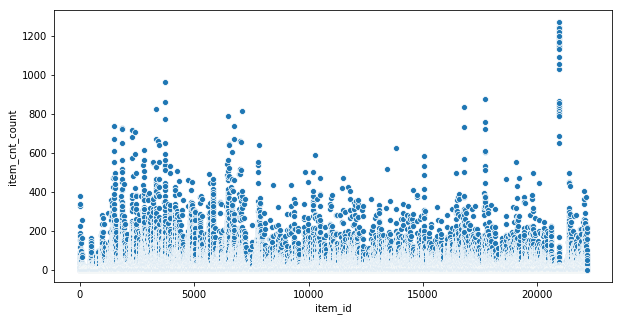

In [114]:
y = agg_all_by_item[agg_all_by_item.date_block_num == 0].sort_values('item_id').item_cnt_count.values
y_2 = agg_all_by_item[agg_all_by_item.date_block_num == 15].sort_values('item_id').item_cnt_count.values
y_3 = agg_all_by_item.sort_values('item_id').item_cnt_count.values
x =  agg_all_by_item.sort_values('item_id').item_id.values
plt.figure(figsize=(10,5))
sns.scatterplot(x ='item_id' , y = 'item_cnt_count', data= agg_all_by_item.sort_values('item_id'))
# sns.distplot(x_2, hist = False, label = 15)
# sns.distplot(x_3, hist = False, label = 33)
plt.show()

## By: shop_id and item_id (monthly):
    dic_agg = {'item_price': ['mean','std', 'max', 'min'], 'item_cnt_day': ['sum','count','mean', 'std']}

In [115]:
groups = ['shop_id', 'item_id']
agg_shop_item = monthly_agg(train_0, groups,rename_col= True)
agg_shop_item.columns = ['date_block_num', 'shop_id', 'item_id', 'it_price_shop_mean',
       'it_price_shop_std', 'it_price_shop_max', 'it_price_shop_min',
       'it_cnt_shop_sum', 'it_cnt_shop_count', 'it_cnt_shop_mean',
       'it_cnt_shop_std']
agg_shop_item.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,27.0,33.0,317.0,438.0,471.0
it_price_shop_mean,2499.0,499.0,299.0,299.0,399.0
it_price_shop_std,NaN,NaN,NaN,NaN,0.0
it_price_shop_max,2499.0,499.0,299.0,299.0,399.0
it_price_shop_min,2499.0,499.0,299.0,299.0,399.0
it_cnt_shop_sum,1.0,1.0,1.0,1.0,2.0
it_cnt_shop_count,1.0,1.0,1.0,1.0,2.0
it_cnt_shop_mean,1.0,1.0,1.0,1.0,1.0


## By: shop_id, cat_id and item_id (monthly):
    dic_agg = {'item_price': ['mean','std', 'max', 'min'], 'item_cnt_day': ['sum','count','mean', 'std']}
 To do that we first extract the info about cat_type and item_type from the `item_cat_df` dataframe, then we label encode these features for later use, this was already done and it is stored in `item_cat_ext`.

In [116]:
item_cat_exp.head().T

,0,1,2,3,4
item_category_id,0,1,2,3,4
cat_type,PC,Аксессуары,Аксессуары,Аксессуары,Аксессуары
item_type,Гарнитуры/Наушники,PS2,PS3,PS4,PSP
cat_type_l,0,1,1,1,1
item_type_l,31,11,12,13,15


In [117]:
# Now, join this dataset with train_0
train_0_cat = train_0.join(items_df, on = 'item_id', rsuffix='_').join(item_cat_exp, on = 'item_category_id', rsuffix = "_").drop(['item_name','item_id_','item_category_id_'], axis =1)
train_0_cat.drop(['cat_type', 'item_type'], axis =1, inplace= True)

In [118]:
#  Do the same of rht test_df, extend it:
test_0 = test_df.join(items_df, on = 'item_id', rsuffix='_').join(item_cat_exp, on = 'item_category_id', rsuffix = "_").drop(['item_name','item_id_','item_category_id_'], axis =1)
test_0.drop(['cat_type', 'item_type'], axis =1, inplace = True)

## Aggregate by all combinations
Include aggregations by all combinations of `['shop_id', 'item_category_id', 'cat_type_l', 'item_type_l']`.
The below snippet shows that there are several combinations of such categorical features that we cacn use to predict `['item_price', 'item_cnt']` for the **missing pairs**.

In [133]:
train_0_cat[train_0_cat.cat_type_l == 13].loc[:, ['shop_id', 'item_category_id', 'cat_type_l', 'item_type_l']].head(15)

,shop_id,item_category_id,cat_type_l,item_type_l
1,25,58,13,29
3,25,58,13,29
4,25,56,13,5
5,25,59,13,40
6,25,56,13,5
7,25,55,13,4
8,25,55,13,4
9,25,55,13,4
10,25,55,13,4
11,25,55,13,4


In [119]:
test_0.head()

,ID,shop_id,item_id,item_category_id,cat_type_l,item_type_l
0,0,5,5037,19,5,12
1,1,5,5320,55,13,4
2,2,5,5233,19,5,12
3,3,5,5232,23,5,18
4,4,5,5268,20,5,13


Now, we will use these extended features (regarding categories) to find aggregate values for price and (monthly) count by shop.


In [134]:
# group by shop and category_id, then aggregate price and cnt
groups = ['shop_id','item_category_id']
agg_shop_cat = monthly_agg(train_0_cat, groups, rename_col= True)
agg_shop_cat.columns = ['date_block_num', 'shop_id', 'item_category_id', 'shop_cat_mean_p',
       'shop_cat_std_p', 'shop_cat_max_p', 'shop_cat_min_p',
       'shop_cat_cnt', 'shop_cat_cnt_count', 'shop_cat_cnt_mean',
       'shop_cat_cnt_std']
agg_shop_cat.head().T

,0,1,2,3,4
date_block_num,0.000000,0.00000,0.000000,0.000000,0.000000
shop_id,2.000000,2.00000,2.000000,2.000000,2.000000
item_category_id,2.000000,3.00000,4.000000,5.000000,6.000000
shop_cat_mean_p,2012.334229,499.00000,968.375000,1206.211060,2402.363525
shop_cat_std_p,987.319519,0.00000,685.909363,1028.295654,2285.026123
shop_cat_max_p,3790.000000,499.00000,1990.000000,3490.000000,6990.000000
shop_cat_min_p,550.020020,499.00000,99.000000,279.299988,499.000000
shop_cat_cnt,26.000000,9.00000,10.000000,10.000000,12.000000
shop_cat_cnt_count,24.000000,6.00000,8.000000,9.000000,11.000000
shop_cat_cnt_mean,1.083333,1.50000,1.250000,1.111111,1.090909


In [135]:
# group by shop and cat_type, then aggregate price and cnt
groups = ['shop_id','cat_type_l']
agg_shop_cat_type = monthly_agg(train_0_cat, groups, rename_col= True)
agg_shop_cat_type.columns = ['date_block_num', 'shop_id', 'cat_type_l', 'shop_cat_type_mean_p',
       'shop_cat_type_std_p', 'shop_cat_type_max_p', 'shop_cat_type_min_p',
       'shop_cat_type_cnt', 'shop_cat_type_cnt_count', 'shop_cat_type_cnt_mean',
       'shop_cat_type_cnt_std']
agg_shop_cat_type.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,2.000000,2.000000,2.000000,2.000000,2.000000
cat_type_l,1.000000,4.000000,5.000000,8.000000,9.000000
shop_cat_type_mean_p,1660.671021,12058.394531,1400.968994,482.323273,1665.666626
shop_cat_type_std_p,1384.090942,3391.980957,657.556763,381.098328,577.350281
shop_cat_type_max_p,6990.000000,15990.000000,2799.000000,2999.000000,1999.000000
shop_cat_type_min_p,99.000000,4990.000000,299.500000,28.000000,999.000000
shop_cat_type_cnt,67.000000,20.000000,242.000000,264.000000,3.000000
shop_cat_type_cnt_count,58.000000,19.000000,228.000000,240.000000,3.000000
shop_cat_type_cnt_mean,1.155172,1.052632,1.061404,1.100000,1.000000


In [136]:
# Group by shop and item_type then aggregate price and count
groups = ['shop_id','item_type_l']
agg_shop_it_type = monthly_agg(train_0_cat, groups, rename_col= True)
agg_shop_it_type.columns = ['date_block_num', 'shop_id', 'item_type_l', 'shop_it_type_mean_p',
       'shop_it_type_std_p', 'shop_it_type_max_p', 'shop_it_type_min_p',
       'shop_it_type_cnt', 'shop_it_type_cnt_count', 'shop_it_type_cnt_mean',
       'shop_it_type_cnt_std']
agg_shop_it_type.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,2.000000,2.000000,2.000000,2.000000,2.000000
item_type_l,0.000000,1.000000,2.000000,4.000000,6.000000
shop_it_type_mean_p,1285.714233,532.060181,1038.977051,256.560974,219.447418
shop_it_type_std_p,1382.544312,434.751251,374.173340,72.793556,125.951141
shop_it_type_max_p,3300.000000,1999.000000,1599.000000,499.000000,799.000000
shop_it_type_min_p,300.000000,68.750000,549.000000,149.000000,28.000000
shop_it_type_cnt,7.000000,52.000000,17.000000,41.000000,175.000000
shop_it_type_cnt_count,7.000000,51.000000,17.000000,41.000000,174.000000
shop_it_type_cnt_mean,1.000000,1.019608,1.000000,1.000000,1.005747


In [146]:
groups = ['item_category_id', 'cat_type_l']
agg_cat_cat_type = monthly_agg(train_0_cat, groups, rename_col = True)
agg_cat_cat_type.columns = ['date_block_num', 'item_category_id', 'cat_type_l', 'cat_cat_type_mean_p',
       'cat_cat_type_std_p', 'cat_cat_type_max_p', 'cat_cat_type_min_p',
       'cat_cat_type_cnt', 'cat_cat_type_cnt_count', 'cat_cat_type_cnt_mean',
       'cat_cat_type_cnt_std']
agg_cat_cat_type.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.000000,0.000000,0.000000
item_category_id,0.0,1.0,2.000000,3.000000,4.000000
cat_type_l,0.0,1.0,1.000000,1.000000,1.000000
cat_cat_type_mean_p,148.0,148.0,2103.025146,477.034149,924.378723
cat_cat_type_std_p,NaN,NaN,1131.298706,178.612061,673.062561
cat_cat_type_max_p,148.0,148.0,6990.000000,2490.000000,2490.000000
cat_cat_type_min_p,148.0,148.0,294.000000,242.000000,28.000000
cat_cat_type_cnt,1.0,1.0,1395.000000,441.000000,255.000000
cat_cat_type_cnt_count,1.0,1.0,1258.000000,333.000000,235.000000
cat_cat_type_cnt_mean,1.0,1.0,1.108903,1.324324,1.085106


In [149]:
groups = ['item_category_id', 'item_type_l']
agg_cat_it_type = monthly_agg(train_0_cat, groups, rename_col = True)
agg_cat_it_type.columns = ['date_block_num', 'item_category_id', 'item_type_l', 'cat_it_type_mean_p',
       'cat_it_type_std_p', 'cat_it_type_max_p', 'cat_it_type_min_p',
       'cat_it_type_cnt', 'cat_it_type_cnt_count', 'cat_it_type_cnt_mean',
       'cat_it_type_cnt_std']
agg_cat_it_type.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.000000,0.000000,0.000000
item_category_id,0.0,1.0,2.000000,3.000000,4.000000
item_type_l,31.0,11.0,12.000000,13.000000,15.000000
cat_it_type_mean_p,148.0,148.0,2103.025146,477.034149,924.378723
cat_it_type_std_p,NaN,NaN,1131.298706,178.612061,673.062561
cat_it_type_max_p,148.0,148.0,6990.000000,2490.000000,2490.000000
cat_it_type_min_p,148.0,148.0,294.000000,242.000000,28.000000
cat_it_type_cnt,1.0,1.0,1395.000000,441.000000,255.000000
cat_it_type_cnt_count,1.0,1.0,1258.000000,333.000000,235.000000
cat_it_type_cnt_mean,1.0,1.0,1.108903,1.324324,1.085106


In [155]:
# By category only
groups = ['item_category_id']
agg_cat = monthly_agg(train_0_cat, groups, rename_col = True)
agg_cat.columns = ['date_block_num', 'item_category_id',  'cat_mean_p',
       'cat_std_p', 'cat_max_p', 'cat_min_p',
       'cat_cnt', 'cat_cnt_count', 'cat_cnt_mean',
       'cat_cnt_std']
agg_cat.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.000000,0.000000,0.000000
item_category_id,0.0,1.0,2.000000,3.000000,4.000000
cat_mean_p,148.0,148.0,2103.025146,477.034149,924.378723
cat_std_p,NaN,NaN,1131.298706,178.612061,673.062561
cat_max_p,148.0,148.0,6990.000000,2490.000000,2490.000000
cat_min_p,148.0,148.0,294.000000,242.000000,28.000000
cat_cnt,1.0,1.0,1395.000000,441.000000,255.000000
cat_cnt_count,1.0,1.0,1258.000000,333.000000,235.000000
cat_cnt_mean,1.0,1.0,1.108903,1.324324,1.085106
cat_cnt_std,NaN,NaN,0.378500,0.669861,0.322238


In [160]:
# By cat_type_l only
groups = ['cat_type_l']
agg_cat_type = monthly_agg(train_0_cat, groups, rename_col = True)
agg_cat_type.columns = ['date_block_num', 'cat_type_l',  'cat_type_mean_p',
       'cat_type_std_p', 'cat_type_max_p', 'cat_type_min_p',
       'cat_type_cnt', 'cat_type_cnt_count', 'cat_type_cnt_mean',
       'cat_type_cnt_std']
agg_cat_type.head().T

,0,1,2,3,4
date_block_num,0.0,0.000000,0.000000,0.000000,0.000000
cat_type_l,0.0,1.000000,3.000000,4.000000,5.000000
cat_type_mean_p,148.0,1556.192383,874.824707,12305.436523,1405.780151
cat_type_std_p,NaN,1219.880005,674.041687,3047.583740,717.853882
cat_type_max_p,148.0,12490.000000,3170.000000,15990.000000,3999.000000
cat_type_min_p,148.0,28.000000,97.800003,4544.000000,98.000000
cat_type_cnt,1.0,3594.000000,149.000000,874.000000,18639.000000
cat_type_cnt_count,1.0,3198.000000,43.000000,832.000000,16786.000000
cat_type_cnt_mean,1.0,1.123827,3.465116,1.050481,1.110390
cat_type_cnt_std,NaN,0.405223,2.443152,0.254632,0.435568


In [161]:
# By item_type_l only
groups = ['item_type_l']
agg_it_type = monthly_agg(train_0_cat, groups, rename_col = True)
agg_it_type.columns = ['date_block_num', 'it_type_l',  'it_type_mean_p',
       'it_type_std_p', 'it_type_max_p', 'it_type_min_p',
       'it_type_cnt', 'it_type_cnt_count', 'it_type_cnt_mean',
       'it_type_cnt_std']
agg_it_type.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
it_type_l,0.000000,1.000000,2.000000,4.000000,5.000000
it_type_mean_p,2005.861206,465.066223,1019.416687,265.626862,867.447021
it_type_std_p,2116.877441,334.791840,465.253906,107.419975,335.257874
it_type_max_p,12600.000000,2349.000000,2499.000000,1449.000000,2299.000000
it_type_min_p,124.000000,27.000000,95.000000,22.400000,58.000000
it_type_cnt,682.000000,6132.000000,1645.000000,12538.000000,268.000000
it_type_cnt_count,596.000000,5747.000000,1584.000000,12200.000000,266.000000
it_type_cnt_mean,1.144295,1.066991,1.038510,1.027705,1.007519
it_type_cnt_std,0.448322,0.348835,0.222901,0.183917,0.086547


In [162]:
# By shop_id only
groups = ['shop_id']
agg_shop = monthly_agg(train_0_cat, groups, rename_col = True)
agg_shop.columns = ['date_block_num', 'shop_id',  'shop_mean_p',
       'shop_std_p', 'shop_max_p', 'shop_min_p',
       'shop_cnt', 'shop_cnt_count', 'shop_cnt_mean',
       'shop_cnt_std']
agg_shop.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,2.000000,3.000000,4.000000,6.000000,7.000000
shop_mean_p,959.464600,734.329773,701.648560,753.698120,749.036133
shop_std_p,1757.928223,1098.743286,1263.057129,1217.045288,1299.550415
shop_max_p,15990.000000,15990.000000,15990.000000,15990.000000,15990.000000
shop_min_p,25.000000,28.000000,25.000000,25.000000,28.000000
shop_cnt,1151.000000,767.000000,2117.000000,3699.000000,2498.000000
shop_cnt_count,1066.000000,749.000000,1891.000000,3241.000000,2275.000000
shop_cnt_mean,1.079737,1.024032,1.119513,1.141314,1.098022
shop_cnt_std,0.318775,0.153251,0.481944,0.613450,0.389586


In [137]:
# Group by shop and item_type then aggregate price and count
groups = ['shop_id','item_category_id', 'cat_type_l']
agg_shop_cat_id_type = monthly_agg(train_0_cat, groups, rename_col= True)
agg_shop_cat_id_type.columns = ['date_block_num', 'shop_id', 'item_category_id' , 'cat_type_l', 'shop_cat_id_type_mean_p',
       'shop_cat_id_type_std_p', 'shop_cat_id_type_max_p', 'shop_cat_id_type_min_p',
       'shop_cat_id_type_cnt', 'shop_cat_id_type_cnt_count', 'shop_cat_id_type_cnt_mean',
       'shop_cat_id_type_cnt_std']
agg_shop_cat_id_type.head().T

,0,1,2,3,4
date_block_num,0.000000,0.00000,0.000000,0.000000,0.000000
shop_id,2.000000,2.00000,2.000000,2.000000,2.000000
item_category_id,2.000000,3.00000,4.000000,5.000000,6.000000
cat_type_l,1.000000,1.00000,1.000000,1.000000,1.000000
shop_cat_id_type_mean_p,2012.334229,499.00000,968.375000,1206.211060,2402.363525
shop_cat_id_type_std_p,987.319519,0.00000,685.909363,1028.295654,2285.026123
shop_cat_id_type_max_p,3790.000000,499.00000,1990.000000,3490.000000,6990.000000
shop_cat_id_type_min_p,550.020020,499.00000,99.000000,279.299988,499.000000
shop_cat_id_type_cnt,26.000000,9.00000,10.000000,10.000000,12.000000
shop_cat_id_type_cnt_count,24.000000,6.00000,8.000000,9.000000,11.000000


In [138]:
# Group by shop and item_type then aggregate price and count
groups = ['shop_id','item_category_id', 'item_type_l']
agg_shop_cat_it_type = monthly_agg(train_0_cat, groups, rename_col= True)
agg_shop_cat_it_type.columns = ['date_block_num', 'shop_id', 'item_category_id' , 'item_type_l', 'shop_cat_it_type_mean_p',
       'shop_cat_it_type_std_p', 'shop_cat_it_type_max_p', 'shop_cat_it_type_min_p',
       'shop_cat_it_type_cnt', 'shop_cat_it_type_cnt_count', 'shop_cat_it_type_cnt_mean',
       'shop_cat_it_type_cnt_std']
agg_shop_cat_it_type.head().T

,0,1,2,3,4
date_block_num,0.000000,0.00000,0.000000,0.000000,0.000000
shop_id,2.000000,2.00000,2.000000,2.000000,2.000000
item_category_id,2.000000,3.00000,4.000000,5.000000,6.000000
item_type_l,12.000000,13.00000,15.000000,16.000000,18.000000
shop_cat_it_type_mean_p,2012.334229,499.00000,968.375000,1206.211060,2402.363525
shop_cat_it_type_std_p,987.319519,0.00000,685.909363,1028.295654,2285.026123
shop_cat_it_type_max_p,3790.000000,499.00000,1990.000000,3490.000000,6990.000000
shop_cat_it_type_min_p,550.020020,499.00000,99.000000,279.299988,499.000000
shop_cat_it_type_cnt,26.000000,9.00000,10.000000,10.000000,12.000000
shop_cat_it_type_cnt_count,24.000000,6.00000,8.000000,9.000000,11.000000


## Join the aggregated datasets:
We need to join the aggregated datasets in order to join with the test_0 dataset next. We want:
        
        ['date_block_num', 'shop_id ', 'item_category_id', 'cat_type_l', 'item_type_l', .... aggregated ] 

In [168]:
train_0_cat.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,cat_type_l,item_type_l
0,2013-02-01,0,59,22154,999.000000,1,37,11,1
1,2013-03-01,0,25,2552,899.000000,1,58,13,29
3,2013-06-01,0,25,2554,1709.050049,1,58,13,29
4,2013-01-15,0,25,2555,1099.000000,1,56,13,5
5,2013-10-01,0,25,2564,349.000000,1,59,13,40


In [176]:
groups = ['shop_id', 'item_id', 'cat_type_l']
fill_0 = monthly_agg(train_0_cat, groups, rename_col= True) 
fill_0.columns = ['date_block_num', 'shop_id', 'item_id', 'shop_it_mean_p',
       'shop_it_std_p', 'shop_it_max_p', 'shop_it_min_p',
       'shop_it_cnt', 'shop_it_cnt_count', 'shop_it_cnt_mean',
       'shop_it_cnt_std']
fill_0.head().T


,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,27.0,33.0,317.0,438.0,471.0
shop_it_mean_p,2499.0,499.0,299.0,299.0,399.0
shop_it_std_p,NaN,NaN,NaN,NaN,0.0
shop_it_max_p,2499.0,499.0,299.0,299.0,399.0
shop_it_min_p,2499.0,499.0,299.0,299.0,399.0
shop_it_cnt,1.0,1.0,1.0,1.0,2.0
shop_it_cnt_count,1.0,1.0,1.0,1.0,2.0
shop_it_cnt_mean,1.0,1.0,1.0,1.0,1.0


Notice, that the `shop_it_cnt` column is actually our target label.

ok, now we can begin joining the datasets, let's see:

In [177]:
fill_1 = fill_0.merge(agg_shop, on = ['date_block_num', 'shop_id'], how ='left')
fill_1.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,2.000000,2.000000,2.000000,2.000000,2.000000
item_id,27.000000,33.000000,317.000000,438.000000,471.000000
shop_it_mean_p,2499.000000,499.000000,299.000000,299.000000,399.000000
shop_it_std_p,NaN,NaN,NaN,NaN,0.000000
shop_it_max_p,2499.000000,499.000000,299.000000,299.000000,399.000000
shop_it_min_p,2499.000000,499.000000,299.000000,299.000000,399.000000
shop_it_cnt,1.000000,1.000000,1.000000,1.000000,2.000000
shop_it_cnt_count,1.000000,1.000000,1.000000,1.000000,2.000000
shop_it_cnt_mean,1.000000,1.000000,1.000000,1.000000,1.000000


In [179]:
fill_1.merge(agg_shop_cat_type, on = ['date_block_num', 'shop_id', 'cat_type_l'], how='left').head().T

KeyError: 'cat_type_l'

In [ ]:
fill_2 = fill_1.merge(agg_shop_it_type, on = ['date_block_num', 'shop_id', 'item_type_l'], how = 'left').head().T

In [ ]:
fill_2.head()

In [ ]:
agg_shop_it_type.head().T

In [ ]:
agg_shop_cat.head().T

In [ ]:
# price and count aggregation by month -we always do it monthly - and item_id (so, we're lookind at the whole store globally) 
g_price_train_0 = train_0.sort_values('date').groupby(['date_block_num','item_id'], as_index = False)
agg_price_train_0 = g_price_train_0.agg({'item_price': ['mean','std', 'max', 'min'], 'item_cnt_day': ['sum','count','mean', 'std']})
agg_price_train_0.columns = ['date_block_num', 'item_id', 'item_mean_pr','item_std_pr','item_max_pr','item_min_pr', 'item_all_cnt','item_all_transactions', 'item_all_mean_cnt','item_std_all_cnt']
agg_price_train_0.fillna(0, inplace = True)
agg_price_train_0.head()

In [ ]:
pre_train_by_item = pd.merge(blank_df, agg_all_by_item, on=['date_block_num', 'item_id'], how = 'left')

In [ ]:
pre_train_by_item[pre_train_by_item.isnull()]

In [ ]:
#  Not just yet, lets perform feature engineering before doing this.
# train_1 = blank_df.join(items_df, on='item_id', rsuffix='_').join(shops_df, on='shop_id', rsuffix='_').join(item_cat_df, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
# train_1.head().T

In [ ]:
train_by_month = train_1.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_by_month = train_by_month.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_by_month.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
train_by_month.head(20).T

In [ ]:
pd.merge(blank_df, train_by_month, on=['date_block_num','shop_id','item_id'], how='left')

In [ ]:
print('train shape: {}'.format(train.shape))
print('time period:\n\t start -> {} \n\t  end -> {} '.format(train['date'].min().date(), train['date'].max().date()))

Let us look for items that were not sold during the last 6 months. 
 * 12391 out of 21807 (~57%) of items have item_cnt_month = 0, this is, no sells. 
 * Do we get rid of these items?  I don't think so, the model has to see pairs with 0 sells (I think). They're part of the distribution


In [ ]:
sales_by_item_id = sales_train_df.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

Predictions are asked at a monthly level (for the 34th month) which encompass Dec15/Jan16, so we might have a very strong seasonal component.

Let's group data by month > shop_id > item_category_id > item_id and then aggregate data concerning sales and price, this is:

In [ ]:
train_month = train.sort_values('date').groupby(['date_block_num','shop_id', 'item_category_id', 'item_id'], as_index = False).agg({'item_price': 'mean', 'item_cnt_day':['sum', 'mean','count']})
train_month.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
train_month.head(10).T

In [ ]:
train_month.describe()

In [ ]:
shop_unique = pd.DataFrame(sorted(train_month['shop_id'].unique()))
item_unique = pd.DataFrame(sorted(train_month['item_id'].unique()))

In [ ]:
train_month['shop_id'].unique()

In [ ]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_month = pd.merge(blank_df, train_month, on=['date_block_num','shop_id','item_id'], how='left')
train_month.fillna(0, inplace=True)

In [ ]:
# we need to fill this database more carefully, at least we should retrieve the item_category_id for each pair. The above code is just filling in 0 for every NaN value
# this cannot be good for the model, but let's continue for the purpose of having a first complete pipeline .
train_month.head().T